In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, root_mean_squared_error, top_k_accuracy_score
from torchmetrics.functional import r2_score as r2_loss
from sklearn.model_selection import train_test_split
from itertools import product

import torch
import torch.nn as nn
import torch.optim as optim
import sys 
import os
from torch.utils.data import DataLoader, TensorDataset

sys.path.append(os.path.dirname(os.getcwd())) 
from source.autoencoder import VariationalAutoencoder

In [196]:
df = pd.read_csv('../data/network_model_dataset_7200.csv', index_col=0)
tmax = df.values.shape[1] - 5 # number of simulation days
# 5 - number of parameters of the network model
df['ts'] = df[[str(day_index) for day_index in range(tmax)]].values.tolist()
data = df[['beta', 'alpha', 'ts']]

In [197]:
print(r'Диапазон параметров beta:[{}, {}], alpha:[{}, {}]'.format(df['beta'].min(), df['beta'].max(),
                                                                             df['alpha'].min(),
                                                                             df['alpha'].max()))

Диапазон параметров beta:[0.1, 0.9899999999999995], alpha:[0.2, 0.9900000000000008]


In [198]:
X_train, X_test, y_train, y_test =  train_test_split(data.drop(columns=['ts']), 
                                                     data.ts.values, 
                                                     test_size=0.33, 
                                                     random_state=42)
X_train, X_test = X_train.values, X_test.values

In [199]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)

In [200]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [201]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [202]:
def predict(model, input):
    custom_data_tensor = torch.tensor(input, dtype=torch.float32)
    custom_data_tensor = custom_data_tensor.to(device)

    with torch.no_grad():
        model.eval()
        pred, _, _ = model(custom_data_tensor)
    return pred.detach().cpu()

In [214]:
def test(model, X_test, y_test):
    r2_sum = []
    for (x, y) in zip(X_test, y_test):
        with torch.no_grad():
            model.eval()
            pred = predict(model, x)
            r2_sum.append(r2_score(y, pred))
    print(f"R2 Score: {np.array(r2_sum).mean()}")

In [60]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [204]:
def warmup_loss(epoch, n_epochs, criterion, steps, pred, mu, logvar, gt, use=True):
    if use:
        if epoch/n_epochs < steps:
            loss = criterion(pred ,gt)
        else:
            mse_loss = criterion(pred, gt)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = mse_loss + kl_loss
    else:
        loss = criterion(pred, gt)

    return loss

In [205]:
def train(model, n_epochs, train_loader, criterion, optimizer, scheduler=None):
    tb = SummaryWriter()

    for epoch in tqdm(range(n_epochs)):
        model.train()

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred, mu, logvar = model(X_batch.to(device))

            loss = warmup_loss(epoch, n_epochs, criterion, 0, pred, mu, logvar, y_batch.to(device), use=False)

            loss.backward()
            optimizer.step()

            if scheduler != None:
                scheduler.step()

        tb.add_scalar("Total loss", loss.item(), epoch)
    tb.close()

In [206]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torchmetrics import MeanSquaredError
# from pytorch_lightning import LightningModule, Trainer
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [208]:
hidden_size = 512
latent_size = 256
n_epochs = 50

mse_cr = F.mse_loss
r2_cr = r2_loss
vae = VariationalAutoencoder(input_size=2, hidden_size=hidden_size, latent_size=latent_size, output_size=tmax).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=5e-4)

In [209]:
lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=1e-6)

In [ ]:
train(vae, n_epochs, train_loader, mse_cr, optimizer, lr_sched)

 26%|██▌       | 13/50 [01:35<04:23,  7.12s/it]

In [211]:
test(vae, X_test, y_test)

R2 Score: 0.11546588260115999


In [212]:
def plot_test(params, gt, fontsize=14):
    surrogate_sim = predict(vae, params).numpy()
    r2 = r2_score(gt, surrogate_sim)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(gt, label='Network model', marker='o', color='OrangeRed')
    ax.plot(surrogate_sim, lw=3, color='RoyalBlue', label='Surrogate model')

    ax.set_xlabel('Days', fontsize=1.2*fontsize)
    ax.set_ylabel('Incidence', fontsize=1.2*fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.legend(fontsize=1.2*fontsize)
    ax.grid()
    return fig

/var/folders/z9/3mmkvbxj1g5gk4qrms1dj77h0000gn/T/ipykernel_91127/350738424.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 6))


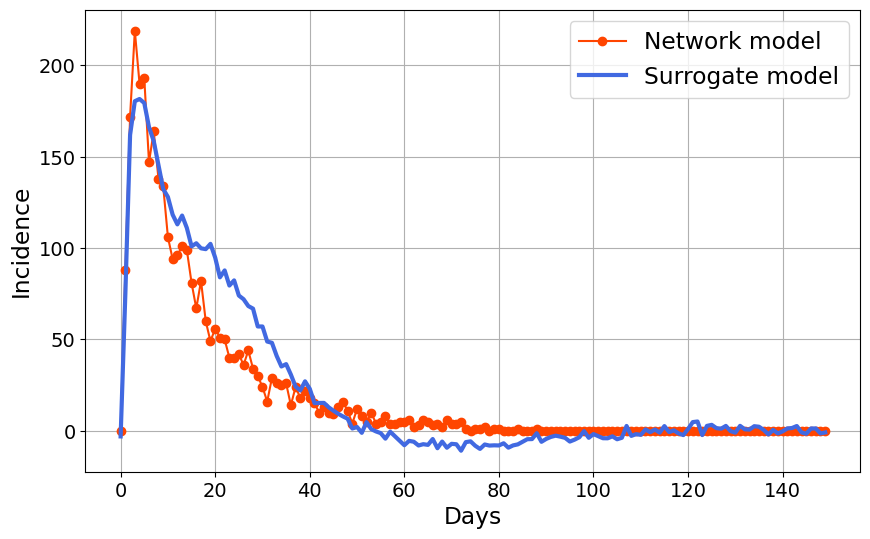

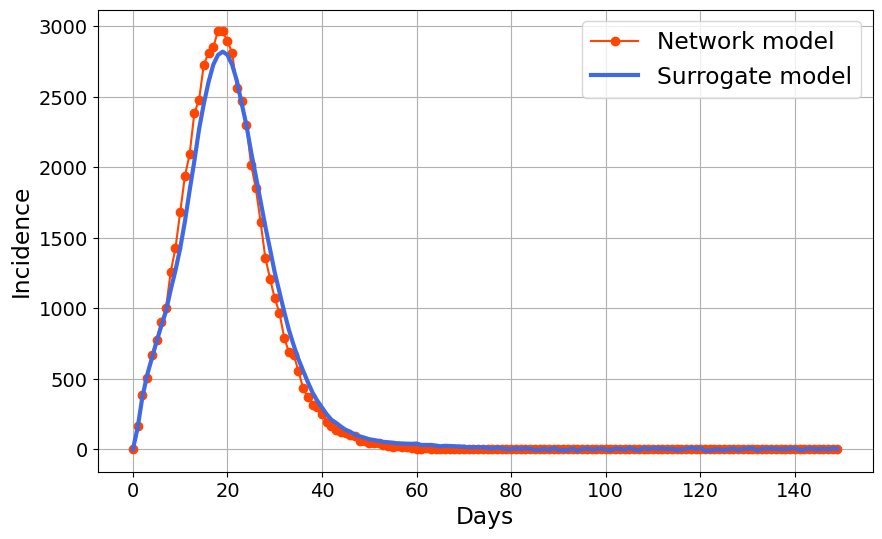

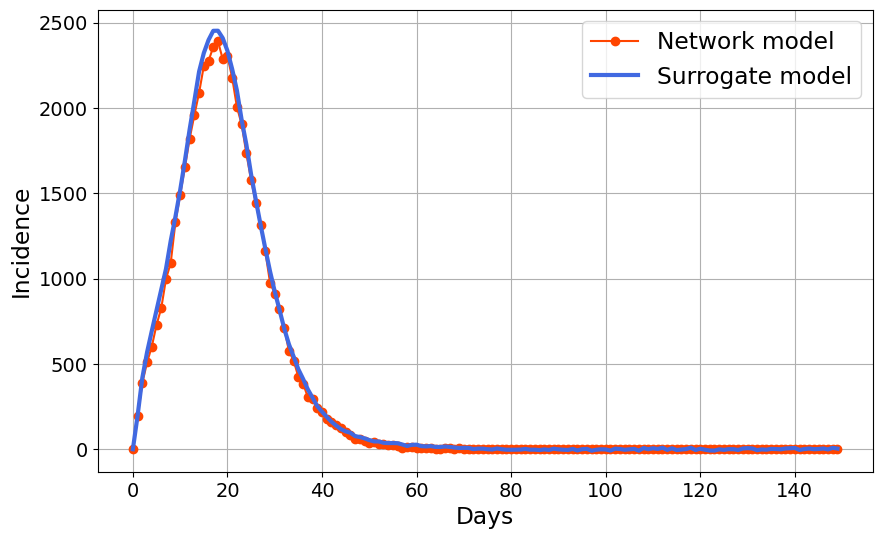

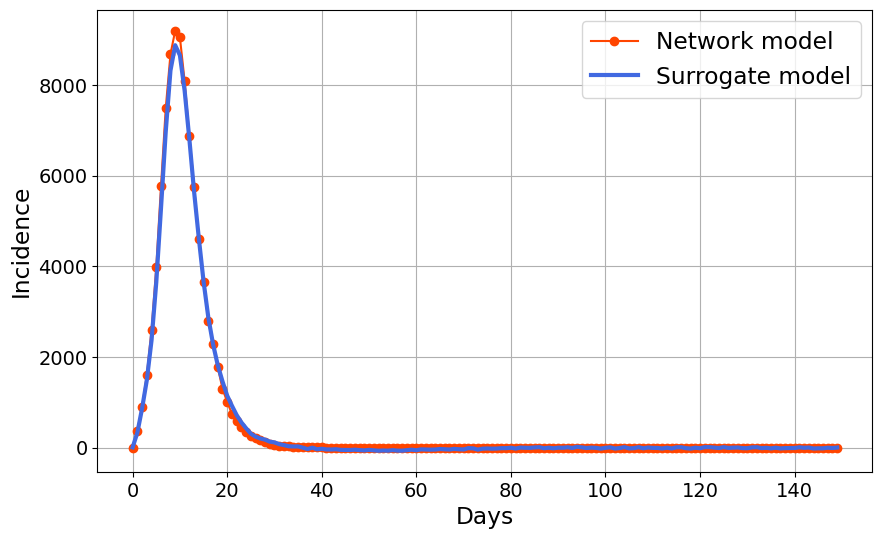

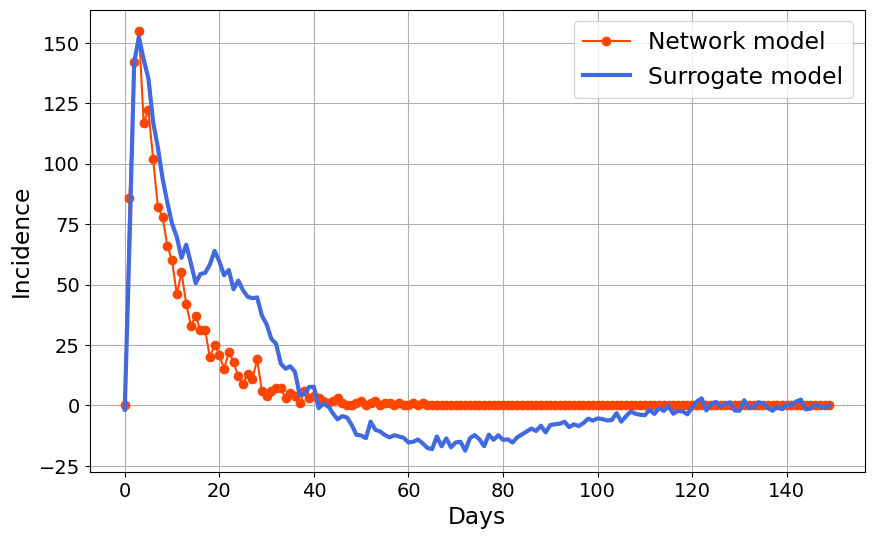

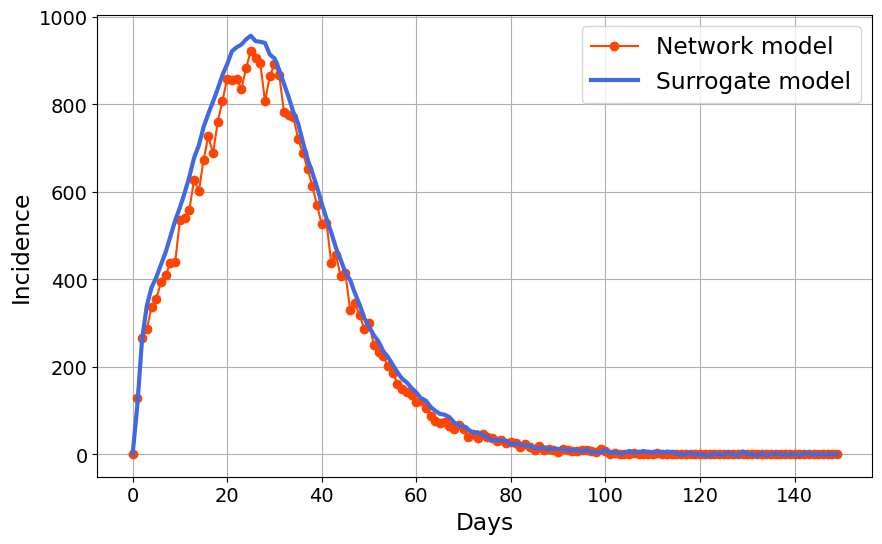

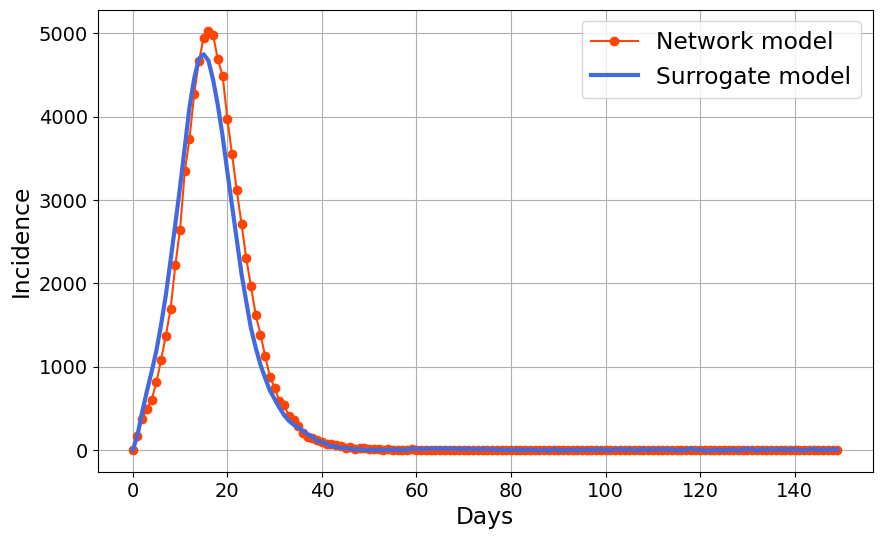

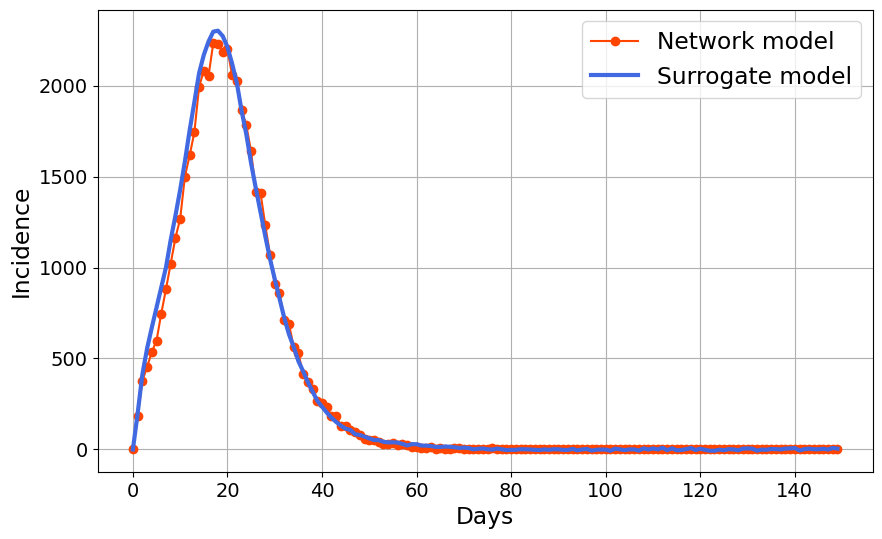

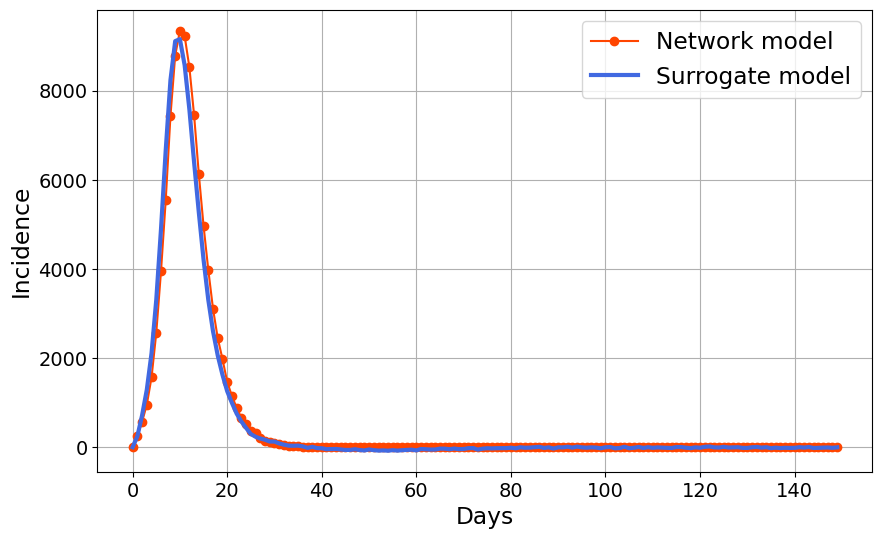

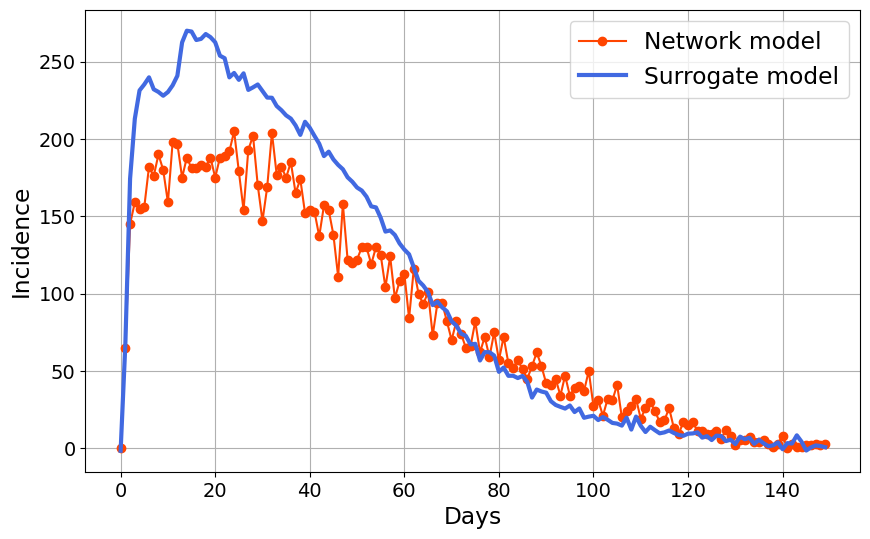

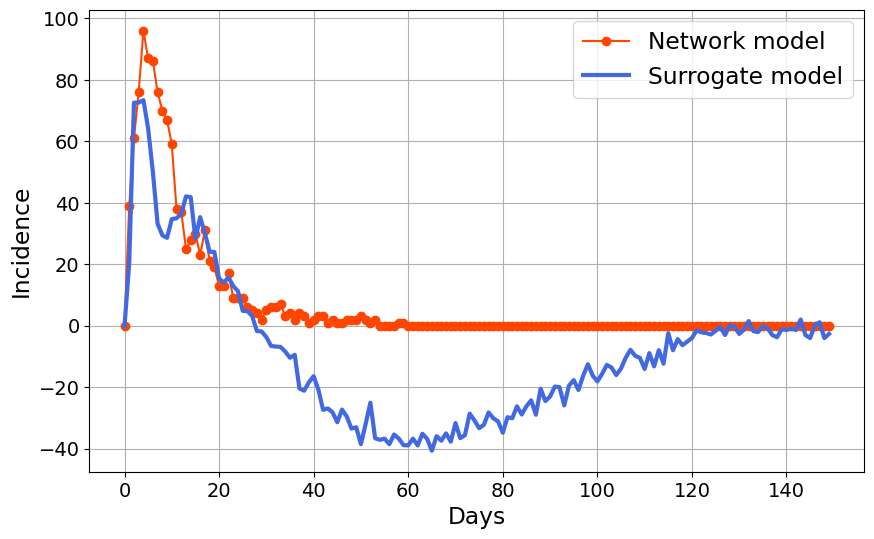

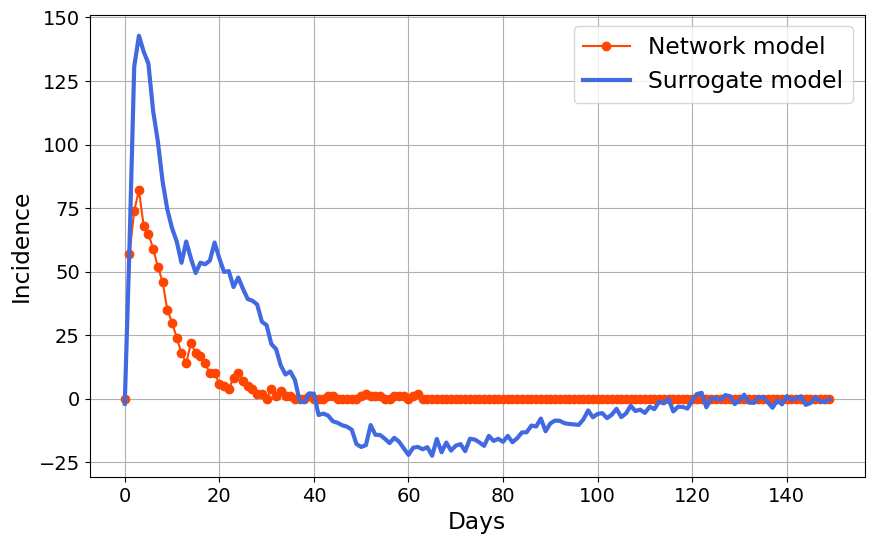

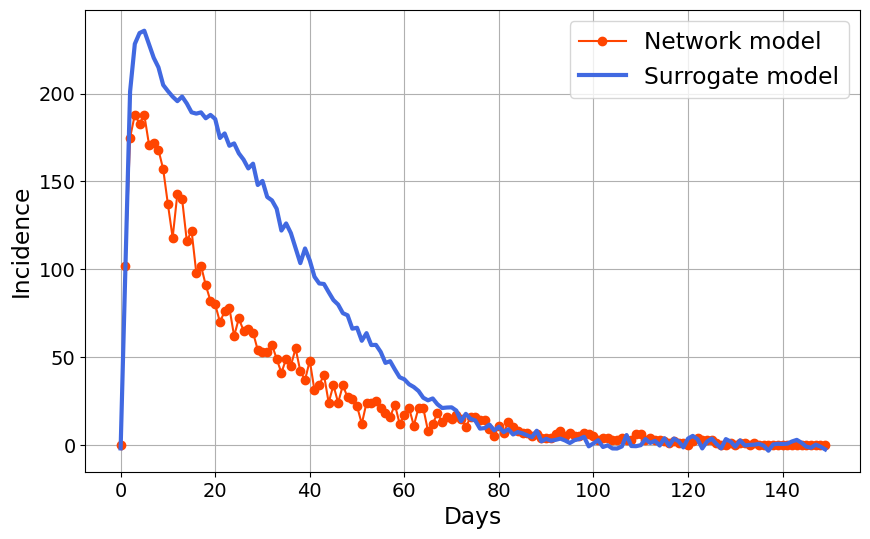

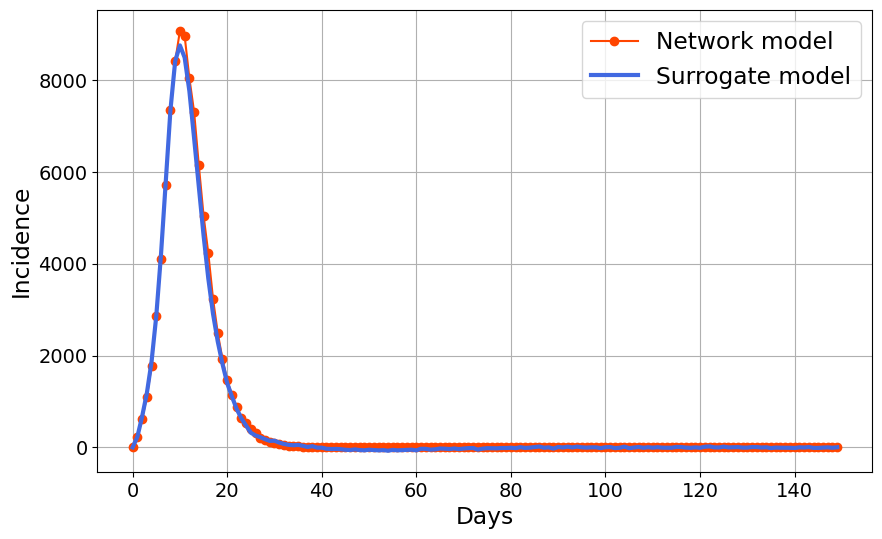

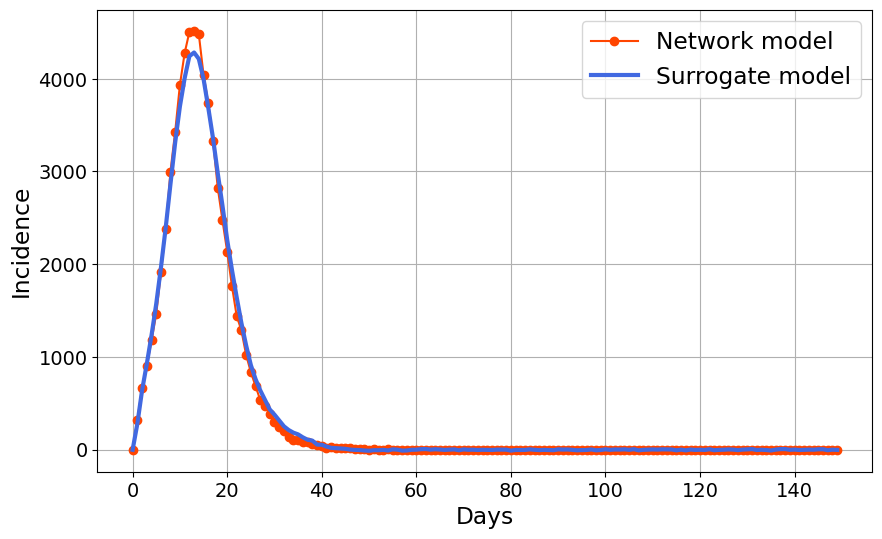

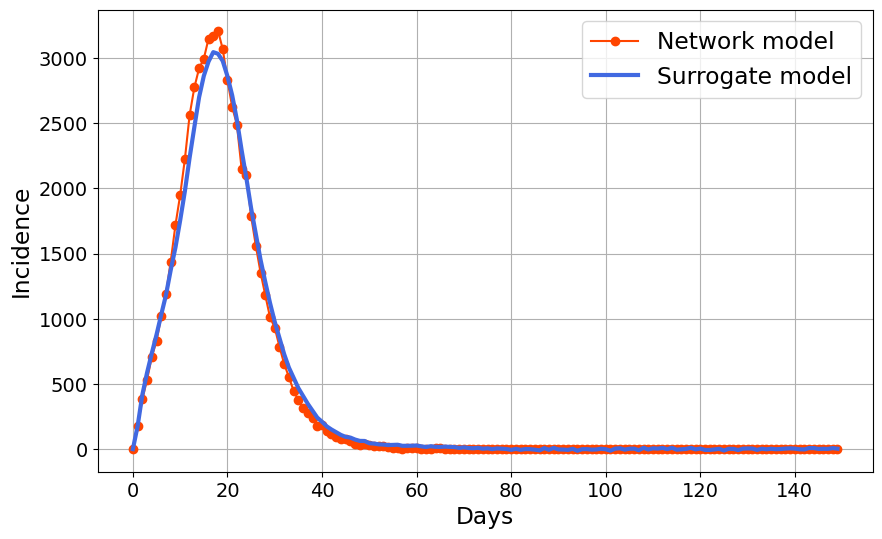

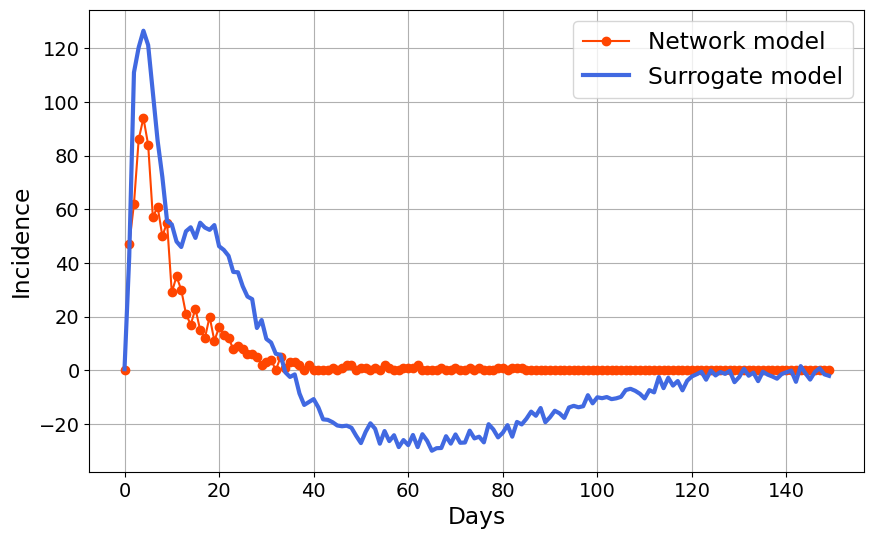

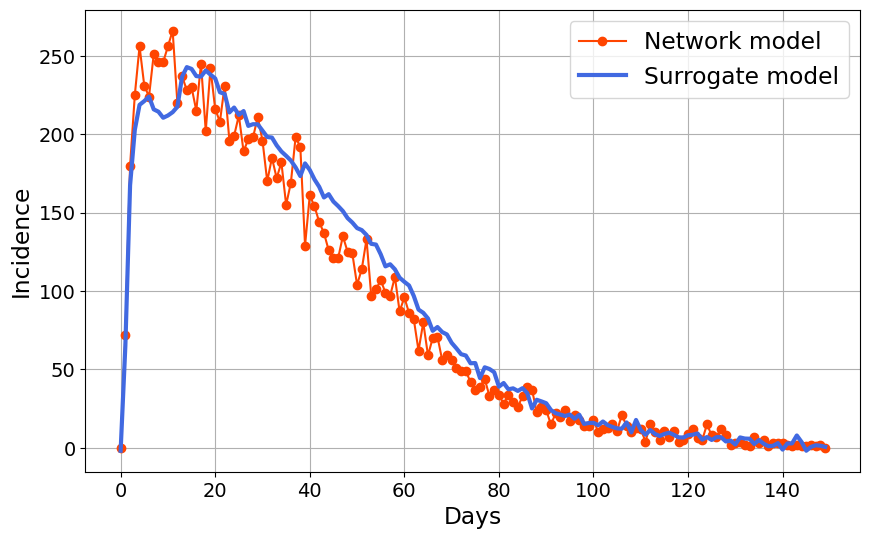

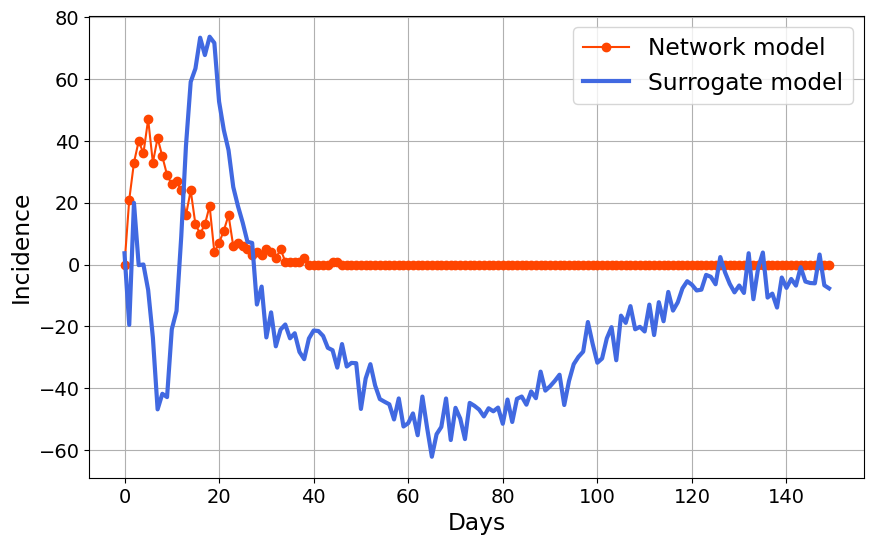

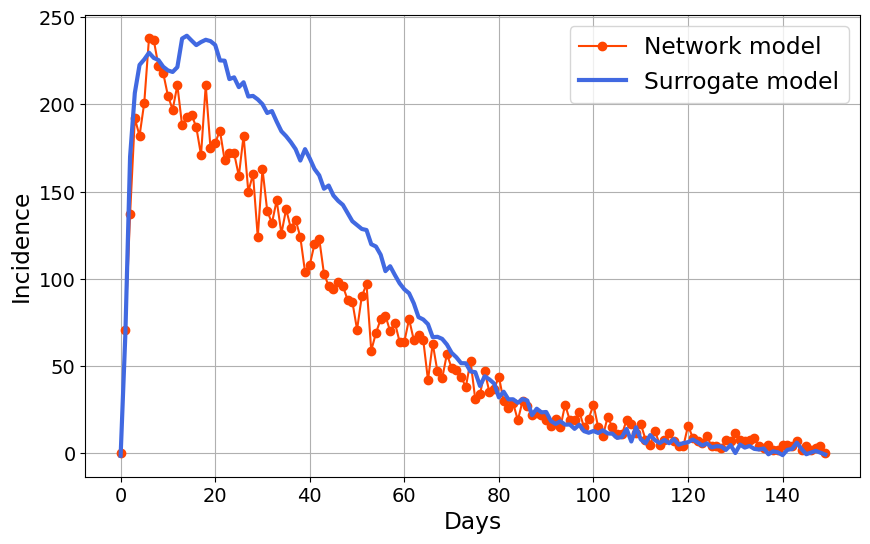

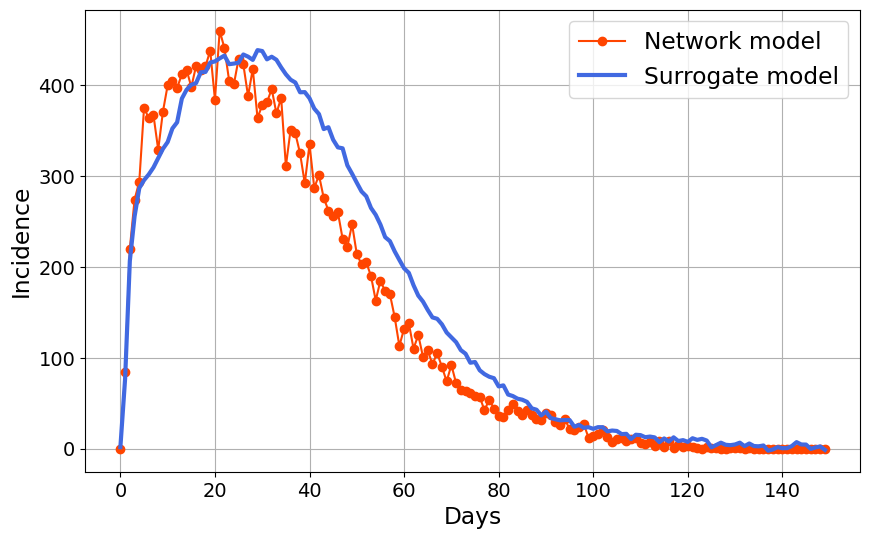

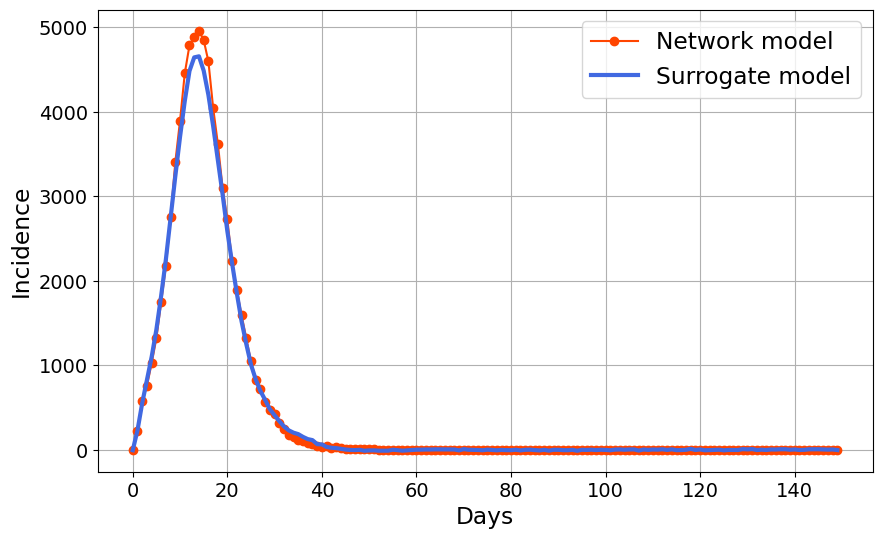

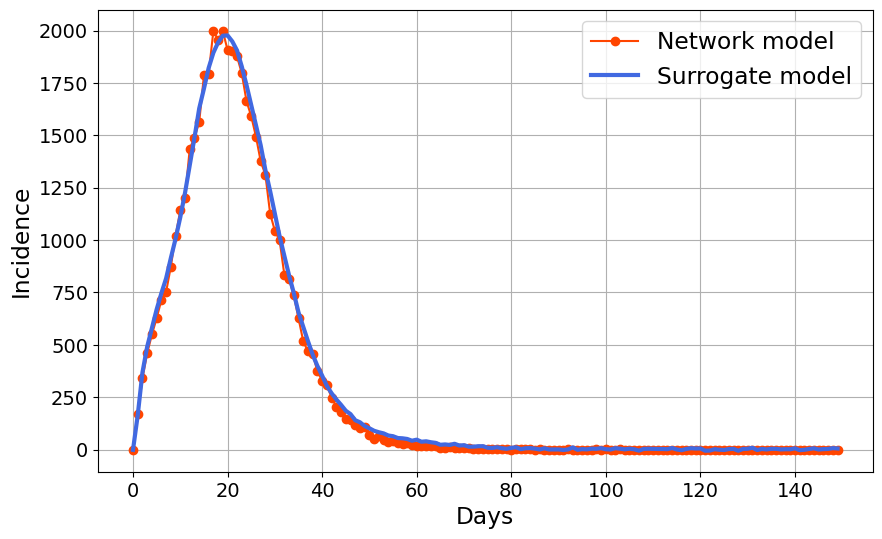

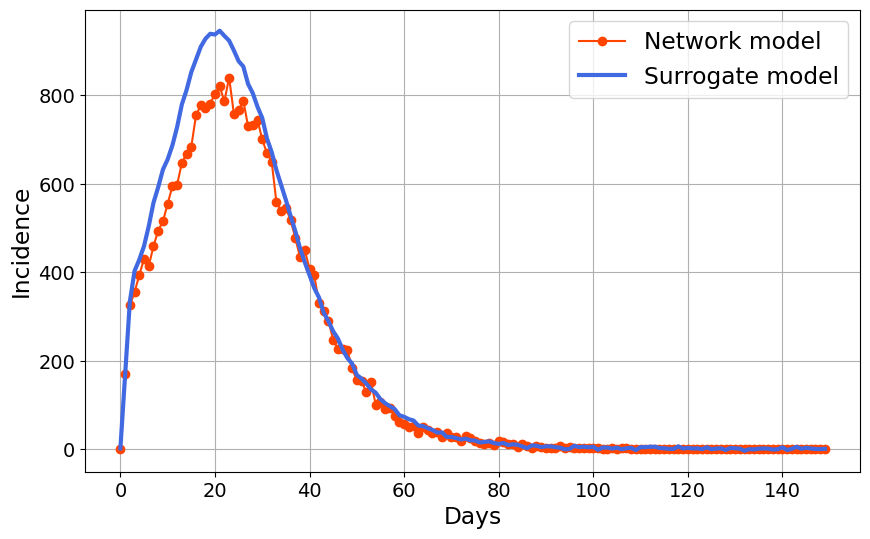

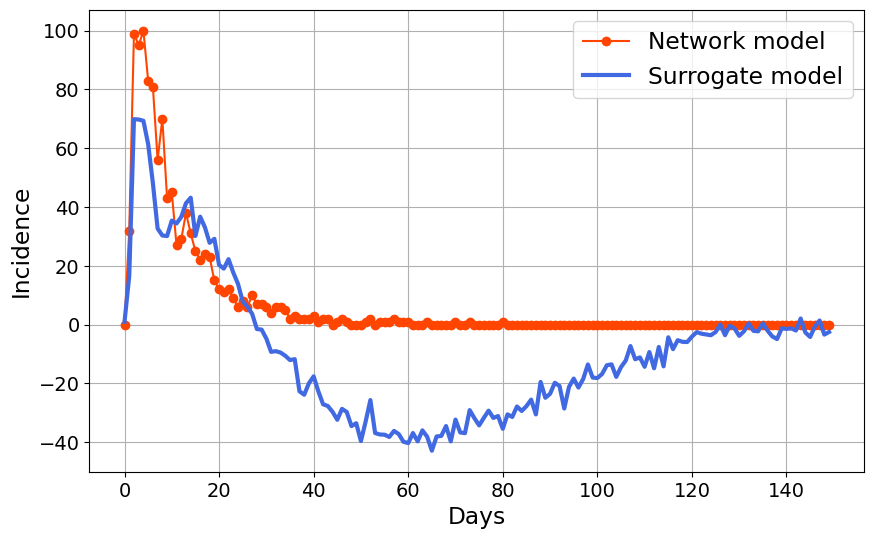

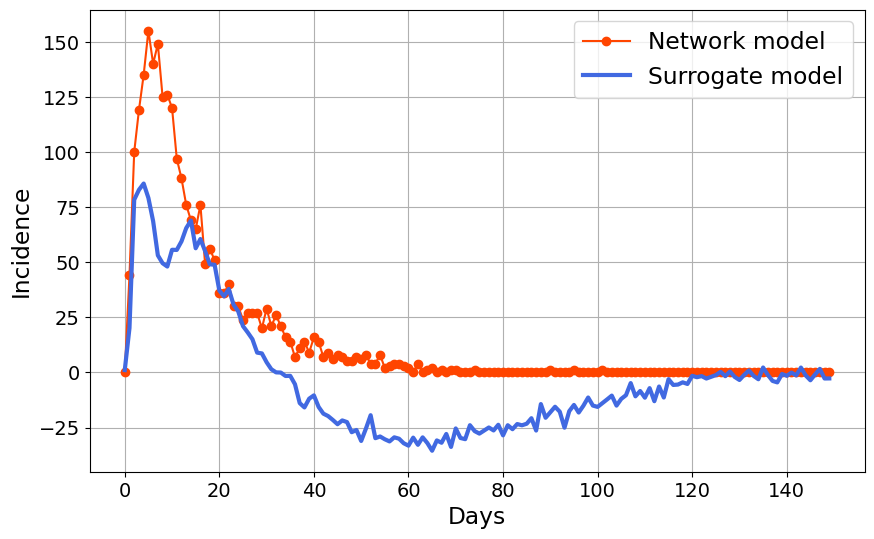

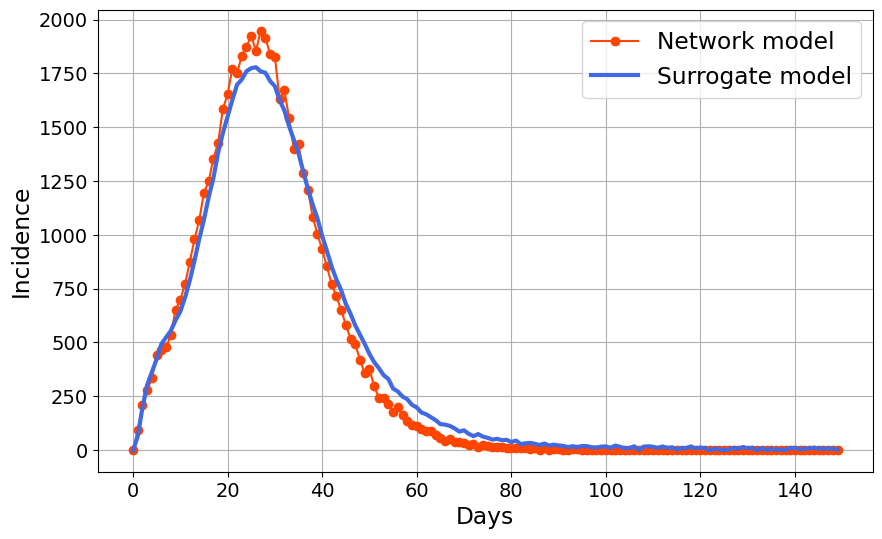

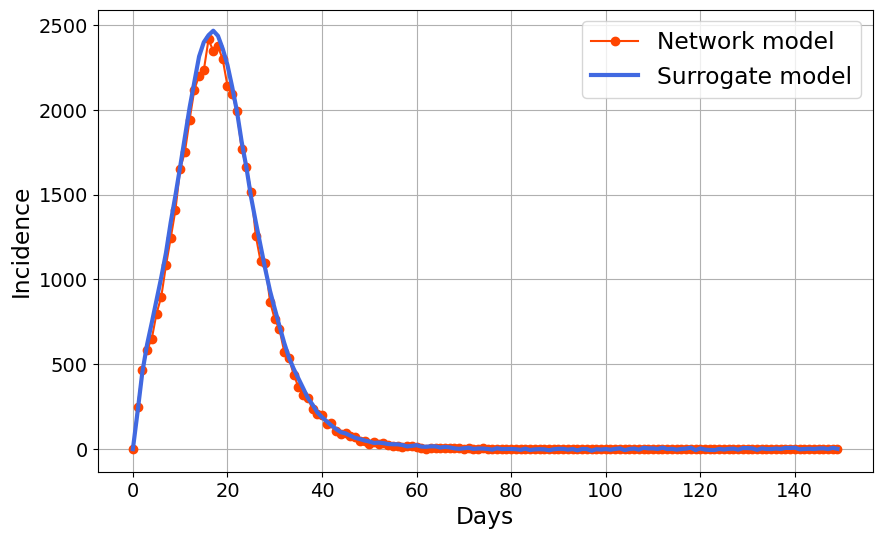

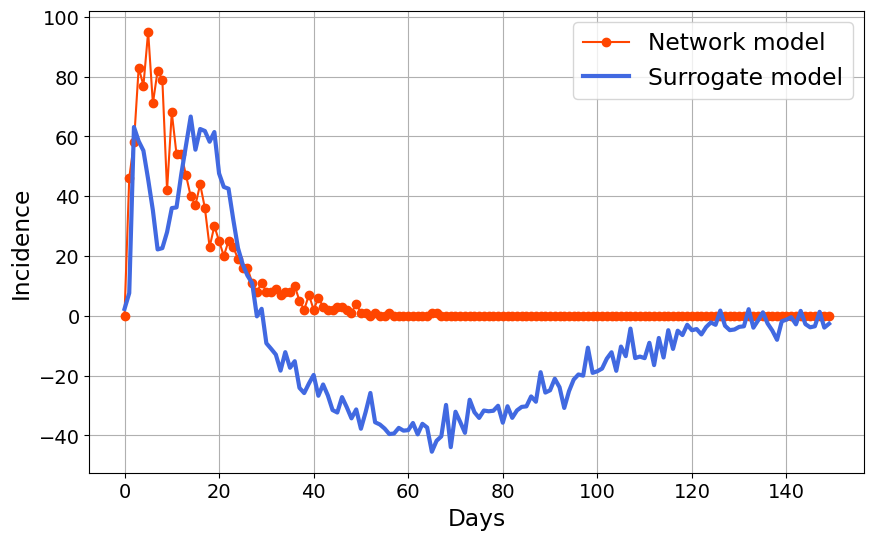

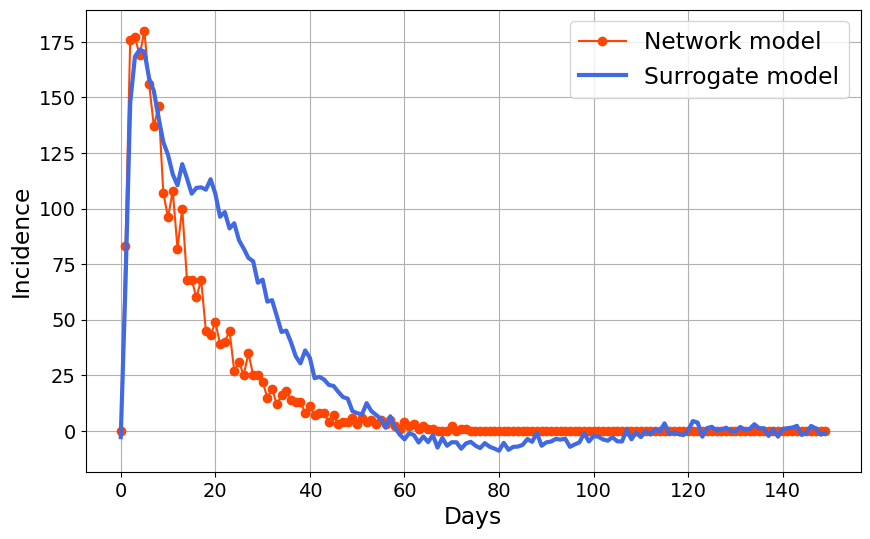

In [213]:
for _ in range(30):
    index = random.randint(0, len(y_test))
    fig = plot_test(X_test[index], y_test[index])
    fig.savefig(r'../figures/surrogate_network_model_comparison_{}.png'.format(index), 
                dpi=600, bbox_inches='tight')

In [127]:
R2_test = []
for index, params in enumerate(X_test):
    prediction = predict(vae, params)
    R2_test.append(r2_score(prediction, y_test[index]))

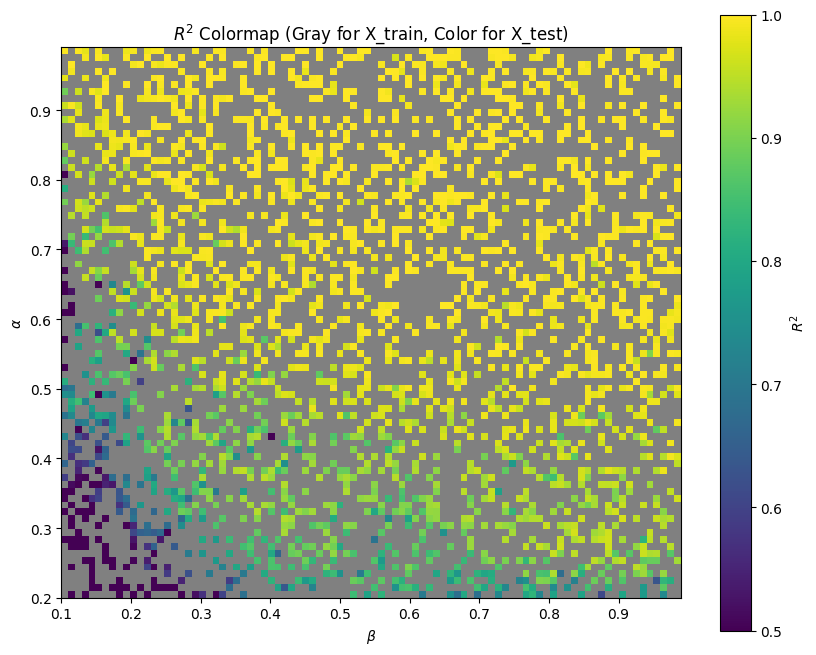

In [133]:
param_1_vals = np.sort(np.unique(np.concatenate((X_train[:,0], X_test[:,0]))))
param_2_vals = np.sort(np.unique(np.concatenate((X_train[:,1], X_test[:,1]))))

# Create empty grid
heatmap = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_test):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap[i, j] = r2

# Mask X_train locations
train_mask = np.zeros_like(heatmap, dtype=bool)
for (p1, p2) in X_train:
    i = np.where(param_2_vals == p2)[0]
    j = np.where(param_1_vals == p1)[0]
    if len(i) and len(j):
        train_mask[i[0], j[0]] = True

masked_heatmap = np.ma.masked_array(heatmap, mask=train_mask)

# Plot
plt.figure(figsize=(10, 8))
cmap = plt.cm.viridis.copy()
cmap.set_bad('gray')  # train in gray
img = plt.imshow(masked_heatmap, origin='lower', cmap=cmap, vmin=0.5, vmax=1,
                 extent=[param_1_vals[0], param_1_vals[-1], param_2_vals[0], param_2_vals[-1]])
plt.colorbar(img, label='$R^2$')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\alpha$')
plt.title(r'$R^2$ Colormap (Gray for X_train, Color for X_test)')
plt.savefig('../figures/colomap_network_autoencoder.png', dpi=600, bbox_inches='tight')